# **Personalized Movie Recommendation System using Content-Based and Collaborative Filtering**
- **Name:** Felix Rafael
- **Email:** felixrafaelkwan@gmail.com


### **Objective:**   
This project aims to develop a personalized movie recommendation system by combining Content-Based Filtering and Collaborative Filtering approaches. The Content-Based Filtering component recommends movies by analyzing movie metadata (genres) and finding items similar to those the user liked. The Collaborative Filtering, implemented using Neural Collaborative Filtering (NCF), learns user-item interaction patterns to predict ratings for unseen movies. Together, these models provide accurate and relevant movie recommendations, enhancing user satisfaction and engagement.

###**Dataset source:**
https://www.kaggle.com/datasets/shubhammehta21/movie-lens-small-latest-dataset

# **1. Import Libraries**

In [1]:
# Data manipulation and analysis
import numpy as np
import pandas as pd
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Utility
from google.colab import files
from collections import Counter
# Text Feature Engineering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
# Deep Learning Framework
import tensorflow as tf
from tensorflow.keras import layers, regularizers, models, Model, losses, optimizers, metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# **2. Data Loading**

In [2]:
# Upload kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"felixrafael","key":"a5bee34940bf1c9f01ed1d9d851d9ac3"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download dataset
!kaggle datasets download -d shubhammehta21/movie-lens-small-latest-dataset

Dataset URL: https://www.kaggle.com/datasets/shubhammehta21/movie-lens-small-latest-dataset
License(s): unknown
  0% 0.00/971k [00:00<?, ?B/s]
100% 971k/971k [00:00<00:00, 1.12GB/s]


In [5]:
# Unzip dataset
!unzip movie-lens-small-latest-dataset.zip

Archive:  movie-lens-small-latest-dataset.zip
  inflating: README.txt              
  inflating: links.csv               
  inflating: movies.csv              
  inflating: ratings.csv             
  inflating: tags.csv                


In [6]:
# Read CSV files - Movies.csv & Ratings.csv
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [7]:
# Show the first 5 rows of Movies Datasets
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
# Show the first 5 rows of Ratings Datasets
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# **3. Exploratory Data Analysis (EDA)**

In [9]:
# Display the shape of the Movies and Ratings datasets
for name, df in [('Movies', movies), ('Ratings', ratings)]:
    print(f"{name} dataset: {df.shape[0]} rows × {df.shape[1]} columns")

Movies dataset: 9742 rows × 3 columns
Ratings dataset: 100836 rows × 4 columns


In [10]:
# Display dataset structure and column information for Movies and Ratings
for name, df in [('Movies', movies), ('Ratings', ratings)]:
    print(f"\n{name} Dataset Info:")
    df.info()


Movies Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB

Ratings Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [11]:
# Show overall descriptive statistics for Movies dataset
movies.describe(include="all")

,movieId,title,genres
count,9742.000000,9742,9742
unique,NaN,9737,951
top,NaN,Emma (1996),Drama
freq,NaN,2,1053
mean,42200.353623,NaN,NaN
std,52160.494854,NaN,NaN
min,1.000000,NaN,NaN
25%,3248.250000,NaN,NaN
50%,7300.000000,NaN,NaN
75%,76232.000000,NaN,NaN


In [12]:
# Show overall descriptive statistics for Ratings dataset
ratings.describe(include="all")

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [13]:
# Check for missing values in the Movies and Ratings datasets
for name, df in [('Movies', movies), ('Ratings', ratings)]:
    print(f"\nMissing values in {name} dataset:")
    print(df.isna().sum())


Missing values in Movies dataset:
movieId    0
title      0
genres     0
dtype: int64

Missing values in Ratings dataset:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [14]:
# Check for duplicate rows
for name, df in [('Movies', movies), ('Ratings', ratings)]:
    duplicates = df.duplicated().sum()
    print(f"Duplicate rows in {name} dataset: {duplicates}")

Duplicate rows in Movies dataset: 0
Duplicate rows in Ratings dataset: 0


In [15]:
# Check for duplicate columns
for name, df in [('Movies', movies), ('Ratings', ratings)]:
    duplicated_cols = df.columns[df.columns.duplicated()]
    print(f"Duplicate columns in {name} dataset: {len(duplicated_cols)}")
    if len(duplicated_cols) > 0:
        print("Duplicated columns:", list(duplicated_cols))

Duplicate columns in Movies dataset: 0
Duplicate columns in Ratings dataset: 0


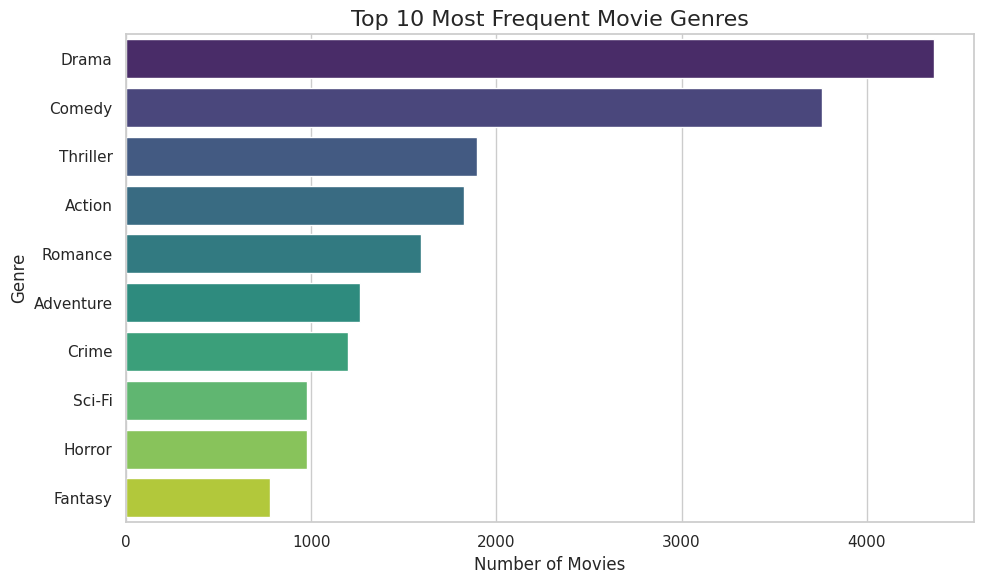

In [16]:
# Count the number of genres
genre_counter = Counter()
for g in movies['genres']:
    genres_split = g.split('|')
    genre_counter.update(genres_split)

# Convert to DataFrame
genre_df = pd.DataFrame(genre_counter.most_common(10), columns=['Genre', 'Count'])

# Visualize the top 10 most frequent movie genres
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(data=genre_df, x='Count', y='Genre', hue='Genre', palette='viridis', dodge=False, legend=False)
plt.title('Top 10 Most Frequent Movie Genres', fontsize=16)
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

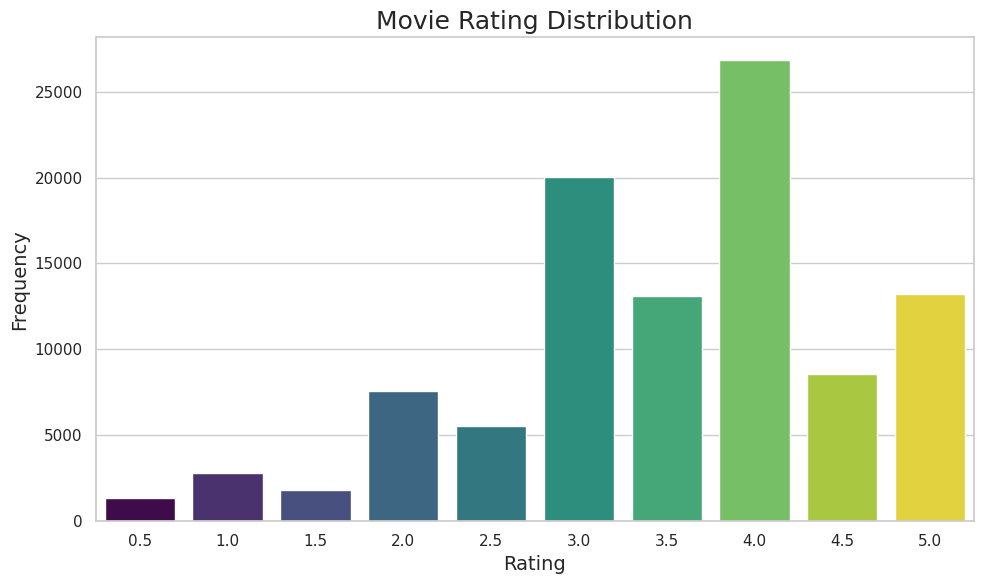

In [61]:
# Visualize the distribution of movie ratings
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='rating', data=ratings, hue='rating', palette='viridis', legend=False)
plt.title('Movie Rating Distribution', fontsize=18)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.tight_layout()
plt.show()

In [18]:
# Merge movie and rating data based on movieId
movie_data = pd.merge(movies, ratings, on='movieId')
# Split genres into a list of individual genres
movies['genres'] = movies['genres'].str.split('|')
# Explode the genre list so each row corresponds to a single genre per movie
movie_data = movies.explode('genres').merge(ratings, on='movieId')
# Group by genre and calculate mean rating and rating count
genre_rating_stats = (
    movie_data
    .groupby('genres')['rating']
    .agg(['mean', 'count'])
    .sort_values(by='count', ascending=False)
)

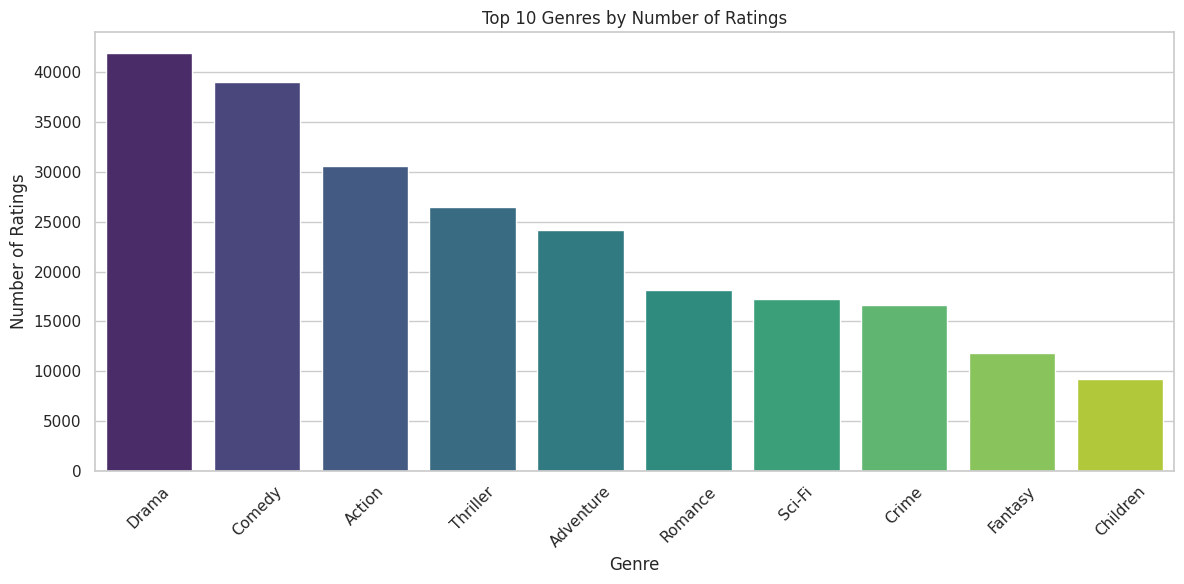

In [19]:
# Visualize the top 10 genres based on number of ratings
top_genres = genre_rating_stats.head(10).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=top_genres, x='genres', y='count', hue='genres', palette='viridis', legend=False)
plt.title('Top 10 Genres by Number of Ratings')
plt.xlabel('Genre')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

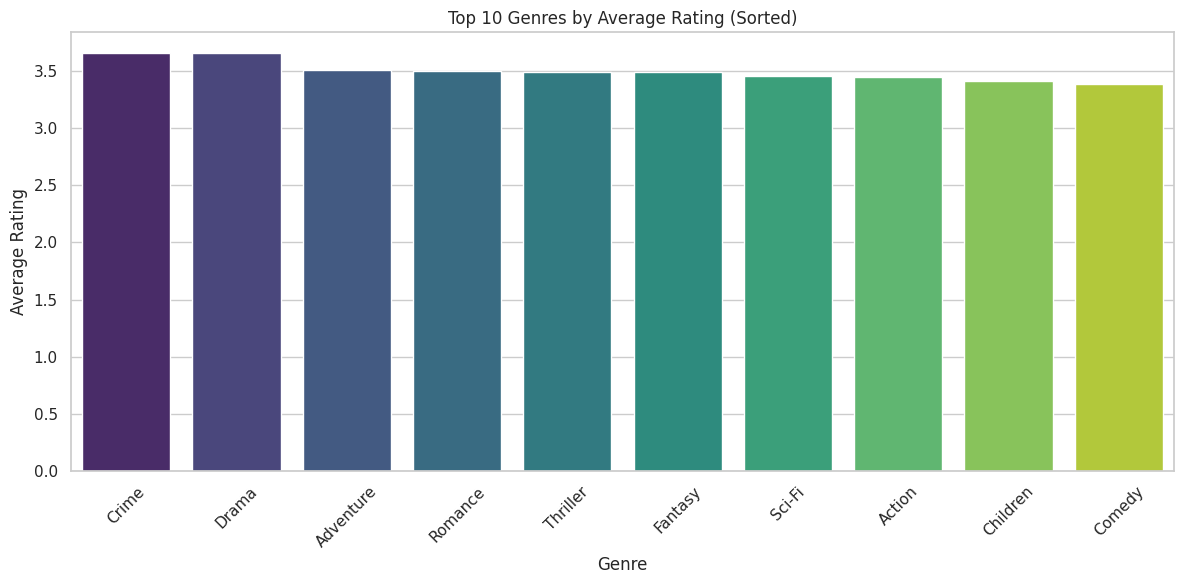

In [20]:
# Visualize the top 10 genres sorted by average rating
top_genres_sorted = top_genres.sort_values(by='mean', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_genres_sorted, x='genres', y='mean', hue='genres', palette='viridis', legend=False)
plt.title('Top 10 Genres by Average Rating (Sorted)')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **4. Data Preprocessing**

## **a. Content Based Filtering**

In [21]:
# Convert the 'genres' column from list back to space-separated string
movies['genres'] = movies['genres'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
# Create a copy of movies dataframe for preprocessing
movie_pre = movies.copy()
# Replace '(no genres listed)' with an empty string
movie_pre['genres'] = movie_pre['genres'].replace('(no genres listed)', '')
# Replace pipe '|' characters with space in the genres string
movie_pre['genres'] = movie_pre['genres'].str.replace('|', ' ')

In [22]:
movie_pre

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action Animation Comedy Fantasy
9738,193583,No Game No Life: Zero (2017),Animation Comedy Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action Animation


## **b. Collaborative Filtering**

In [23]:
# Drop unnecessary columns: Timestamp
ratings = ratings.drop(columns='timestamp')
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [24]:
# Extract the list of unique users from the ratings dataset
unique_users = ratings['userId'].drop_duplicates().tolist()
# Extract the list of unique movies from the ratings dataset
unique_movies = ratings['movieId'].drop_duplicates().tolist()

In [25]:
# Create dictionaries to map original userId and movieId to integer indices
user_mapping = {user_id: idx for idx, user_id in enumerate(unique_users)}
movie_mapping = {movie_id: idx for idx, movie_id in enumerate(unique_movies)}

In [26]:
# Apply the mapping dictionaries to the ratings dataframe to create new columns with integer indices
ratings['user_index'] = ratings['userId'].apply(lambda x: user_mapping[x])
ratings['movie_index'] = ratings['movieId'].apply(lambda x: movie_mapping[x])

In [27]:
# Find the minimum and maximum rating values
min_rating = ratings['rating'].min()
max_rating = ratings['rating'].max()

# Normalize the 'rating' column to a scale from 0 to 1
def normalize_rating(r):
    return (r - min_rating) / (max_rating - min_rating)
ratings['rating_normalized'] = ratings['rating'].map(normalize_rating)

In [28]:
# Shuffle the dataset to ensure random distribution of samples
shuffled_ratings = ratings.sample(frac=1, random_state=42).reset_index(drop=True)
# Extract input features: user and movie indices
features = shuffled_ratings[['user_index', 'movie_index']].to_numpy()
# Extract target output: normalized ratings
targets = shuffled_ratings['rating_normalized'].to_numpy()
# Calculate the cutoff index for 80% training data
train_cutoff = int(0.8 * len(shuffled_ratings))
# Split data into training and validation sets
X_train = features[:train_cutoff]
X_val = features[train_cutoff:]
y_train = targets[:train_cutoff]
y_val = targets[train_cutoff:]
print(f"Training data size: {X_train.shape[0]}")
print(f"Validation data size: {X_val.shape[0]}")

Training data size: 80668
Validation data size: 20168


# **5. Model Development**

## **a. Content Based Filtering**

In [29]:
# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer()
# Fit and transform the 'genres' column to create a TF-IDF feature matrix
tfidf_matrix = tfidf.fit_transform(movies['genres'])

In [30]:
# Calculate cosine similarity between all movie genre vectors
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [31]:
# Recommend movies similar to a given movie based on genre similarity
def recommend_movies(movie_title, movies=movies, cosine_sim=cosine_sim, top_n=10):
    # Find the index of the movie that matches the title
    idx = movies[movies['title'] == movie_title].index[0]
    # Get similarity scores for this movie with all others
    sim_scores = list(enumerate(cosine_sim[idx]))
    # Sort movies by similarity score in descending order, excluding the movie itself
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    # Get the indices of the top N similar movies
    movie_indices = [i[0] for i in sim_scores]
    # Return the titles and genres of the recommended movies
    return movies.iloc[movie_indices][['title', 'genres']]

In [32]:
# Content-Based Movie Recommendation Testing
recommend_movies('Toy Story (1995)', top_n=10)

,title,genres
1706,Antz (1998),Adventure Animation Children Comedy Fantasy
2355,Toy Story 2 (1999),Adventure Animation Children Comedy Fantasy
2809,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure Animation Children Comedy Fantasy
3000,"Emperor's New Groove, The (2000)",Adventure Animation Children Comedy Fantasy
3568,"Monsters, Inc. (2001)",Adventure Animation Children Comedy Fantasy
6194,"Wild, The (2006)",Adventure Animation Children Comedy Fantasy
6486,Shrek the Third (2007),Adventure Animation Children Comedy Fantasy
6948,"Tale of Despereaux, The (2008)",Adventure Animation Children Comedy Fantasy
7760,Asterix and the Vikings (Astérix et les Viking...,Adventure Animation Children Comedy Fantasy
8219,Turbo (2013),Adventure Animation Children Comedy Fantasy


## **b. Collaborative Filtering**

### **1. RecommenderNet**

In [33]:
# RecommenderNet: Neural Collaborative Filtering model using embeddings
#
# This model learns latent factors for users and movies via embedding layers,
# includes user and movie bias terms, and applies dropout regularization.
# The output is a predicted rating (normalized between 0 and 1) via a sigmoid activation.
#
# Inputs:
#   - inputs: Tensor of shape (batch_size, 2), where inputs[:, 0] is user indices,
#             and inputs[:, 1] is movie indices.
#
# Output:
#   - Tensor of predicted ratings in (0,1).
class RecommenderNet(tf.keras.Model):
    def __init__(self, total_users, total_movies, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.total_users = total_users
        self.total_movies = total_movies
        self.embed_dim = embed_dim

        # User embedding and bias
        self.user_emb = layers.Embedding(
            input_dim=total_users,
            output_dim=embed_dim,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(1e-6)
        )
        self.user_bias_emb = layers.Embedding(total_users, 1)

        # Movie embedding and bias
        self.movie_emb = layers.Embedding(
            input_dim=total_movies,
            output_dim=embed_dim,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(1e-6)
        )
        self.movie_bias_emb = layers.Embedding(total_movies, 1)

         # Dropout for regularization
        self.dropout = layers.Dropout(0.2)

    def call(self, inputs, training=False):
        user_input = inputs[:, 0]
        movie_input = inputs[:, 1]

        user_vector = self.dropout(self.user_emb(user_input), training=training)
        user_bias = self.user_bias_emb(user_input)
        movie_vector = self.dropout(self.movie_emb(movie_input), training=training)
        movie_bias = self.movie_bias_emb(movie_input)

        interaction = tf.reduce_sum(user_vector * movie_vector, axis=1, keepdims=True)
        output = interaction + user_bias + movie_bias
        return tf.nn.sigmoid(output)

In [34]:
# Initialize the RecommenderNet model
model = RecommenderNet(total_users=len(user_mapping), total_movies=len(movie_mapping), embed_dim=6)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [35]:
# EarlyStopping callback to stop training when validation loss stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)
# ReduceLROnPlateau callback to reduce learning rate when validation loss plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

In [36]:
# Training the RecommenderNet model
history_recommenderNet = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=25,
    verbose=1,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/25
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0722 - root_mean_squared_error: 0.2685 - val_loss: 0.0525 - val_root_mean_squared_error: 0.2289 - learning_rate: 0.0010
Epoch 2/25
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0475 - root_mean_squared_error: 0.2175 - val_loss: 0.0420 - val_root_mean_squared_error: 0.2041 - learning_rate: 0.0010
Epoch 3/25
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0385 - root_mean_squared_error: 0.1950 - val_loss: 0.0393 - val_root_mean_squared_error: 0.1967 - learning_rate: 0.0010
Epoch 4/25
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0354 - root_mean_squared_error: 0.1864 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1938 - learning_rate: 0.0010
Epoch 5/25
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0335 - root_mean_squared_error: 0.1809 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1923 - learning_rate: 0.0010
Epoch 6/25
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0321 - root_mea

In [37]:
# Function to get top-N movie recommendations for a given user using the trained model
def get_top_n_recommendations(model, user_id, movie_ids, movies_df, N=10):
    # Create an array where user_id repeats for each movie
    user_array = np.array([user_id] * len(movie_ids))
    # Stack user and movie indices to create input pairs for the model
    input_array = np.stack([user_array, movie_ids], axis=1)
    # Predict ratings for all movies for this user
    predictions = model.predict(input_array, verbose=0).flatten()
    # Get indices of top N predicted ratings, sorted descending
    top_indices = np.argsort(predictions)[::-1][:N]
    # Extract movie IDs and predicted scores for the top N movies
    top_movie_ids = movie_ids[top_indices]
    top_scores = predictions[top_indices]
    # Filter movies DataFrame to include only the top recommended movies
    top_movies = movies_df[movies_df['movieId'].isin(top_movie_ids)].copy()
    # Add predicted score (normalized 0-1)
    top_movies['predicted_score'] = top_movies['movieId'].map(dict(zip(top_movie_ids, top_scores)))
    # Convert predicted scores back to rating scale 1-5
    top_movies['predicted_rating'] = top_movies['predicted_score'] * 4 + 1
    # Sort movies by predicted rating descending and reset index for ranking
    top_movies = top_movies.sort_values(by='predicted_rating', ascending=False).reset_index(drop=True)
    top_movies.index += 1  # Start rank index at 1
    # Return movieId, title, and predicted_rating
    return top_movies[['movieId', 'title', 'predicted_rating']]

# Example usage
user_id = 3
all_movie_ids = movies['movieId'].values
top_n = 10
top_recommendations_df = get_top_n_recommendations(model, user_id, all_movie_ids, movies, top_n)
print(top_recommendations_df)

# Tweet-style output of top recommendations
tweet_lines = [f"User {user_id} Top-{top_n} Movie Recommendations:"]
for rank, row in top_recommendations_df.iterrows():
    tweet_lines.append(f"{rank}. {row['title']} (ID: {row['movieId']}) - Predicted Rating: {row['predicted_rating']:.2f}")
tweet_text = "\n".join(tweet_lines)
print("\n--- Top 10 Movie Recommendations ---")
print(tweet_text)

    movieId                                            title  predicted_rating
1      1027             Robin Hood: Prince of Thieves (1991)          4.625222
2       232      Eat Drink Man Woman (Yin shi nan nu) (1994)          4.591430
3        28                                Persuasion (1995)          4.587177
4        16                                    Casino (1995)          4.538779
5       332                     Village of the Damned (1995)          4.491677
6       351                          Corrina, Corrina (1994)          4.488587
7      1136           Monty Python and the Holy Grail (1975)          4.468426
8        72                     Kicking and Screaming (1995)          4.467326
9         4                         Waiting to Exhale (1995)          4.461699
10      722  Haunted World of Edward D. Wood Jr., The (1996)          4.456945

--- Top 10 Movie Recommendations ---
User 3 Top-10 Movie Recommendations:
1. Robin Hood: Prince of Thieves (1991) (ID: 1027) - Pre

### **2. Neural Collaborative Filtering (NCF)**

In [38]:
# NeuralCollaborativeFiltering: Neural Collaborative Filtering model using embeddings and dense layers
#
# This model learns latent factors for users and movies via embedding layers,
# concatenates the embeddings, and passes them through fully connected layers
# with batch normalization, dropout, and L2 regularization.
# The output is a predicted rating (normalized between 0 and 1) via a sigmoid activation.
#
# Inputs:
#   - inputs: list or tuple of two tensors: user indices and movie indices, each of shape (batch_size,)
#
# Output:
#   - Tensor of predicted ratings in (0,1).
num_users = len(user_mapping)
num_items = len(movie_mapping)
embedding_dim = 8
# Input layers
user_input = layers.Input(shape=(), dtype=tf.int32, name='user_input')
item_input = layers.Input(shape=(), dtype=tf.int32, name='item_input')

# Embedding layers with regularization
user_embedding = layers.Embedding(
    input_dim=num_users,
    output_dim=embedding_dim,
    embeddings_regularizer=regularizers.l2(1e-6),
    name='user_embedding'
)(user_input)

item_embedding = layers.Embedding(
    input_dim=num_items,
    output_dim=embedding_dim,
    embeddings_regularizer=regularizers.l2(1e-6),
    name='item_embedding'
)(item_input)

# Concatenate embedding
user_vec = layers.Flatten()(user_embedding)
item_vec = layers.Flatten()(item_embedding)
concat = layers.Concatenate()([user_vec, item_vec])

# Fully connected layers with dropout and L2 regularization
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-6))(concat)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-6))(x)

# Output layer
output = layers.Dense(1, activation='sigmoid')(x)

# Define model
model_ncf = Model(inputs=[user_input, item_input], outputs=output)
model_ncf.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [39]:
# Separate users and items for training and validation
X_train_user = X_train[:, 0]
X_train_item = X_train[:, 1]
X_val_user = X_val[:, 0]
X_val_item = X_val[:, 1]

In [40]:
# EarlyStopping callback to stop training when validation loss stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)
# ReduceLROnPlateau callback to reduce learning rate when validation loss plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

In [41]:
# Training the Neural Collaborative Filtering model
history_ncf = model_ncf.fit(
    [X_train_user, X_train_item], y_train,
    validation_data=([X_val[:, 0], X_val[:, 1]], y_val),
    epochs=30,
    batch_size=64,
    shuffle=True,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.0483 - root_mean_squared_error: 0.2191 - val_loss: 0.0395 - val_root_mean_squared_error: 0.1983 - learning_rate: 0.0010
Epoch 2/30
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0370 - root_mean_squared_error: 0.1921 - val_loss: 0.0381 - val_root_mean_squared_error: 0.1947 - learning_rate: 0.0010
Epoch 3/30
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0334 - root_mean_squared_error: 0.1822 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1943 - learning_rate: 0.0010
Epoch 4/30
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0313 - root_mean_squared_error: 0.1761 - val_loss: 0.0385 - val_root_mean_squared_error: 0.1955 - learning_rate: 0.0010
Epoch 5/30
1247/1261 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0296 - root_mean_squared_error: 0.1711
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0296 - root_mean_squared_error:

In [59]:
# Generate top-N movie recommendations for a given user using a trained NCF model.
def get_top_n_recommendations_ncf(model, user_id, movie_indices, movies_df, movie_mapping, N=10):
    # Create an array with the same user_id repeated for all movies
    user_array = np.array([user_id] * len(movie_indices))
    # Predict ratings using the NCF model
    predictions = model_ncf.predict([user_array, movie_indices], verbose=0).flatten()
    # Get indices of top-N highest predicted ratings
    top_indices = np.argsort(predictions)[::-1][:N]
    top_movie_indices = movie_indices[top_indices]
    top_scores = predictions[top_indices]
    # Map embedding indices back to original movie IDs
    index_to_movie = {idx: mid for mid, idx in movie_mapping.items()}
    top_movie_ids = [index_to_movie[idx] for idx in top_movie_indices]
    # Select movies from movies_df corresponding to top movie IDs
    top_movies = movies_df[movies_df['movieId'].isin(top_movie_ids)].copy()
    # Add columns for predicted score (0-1) and convert to rating scale 0-5
    top_movies['predicted_score'] = top_movies['movieId'].map(dict(zip(top_movie_ids, top_scores)))
    top_movies['predicted_rating'] = top_scores * 5.0
     # Sort movies by predicted_rating descending and reset index starting from 1
    top_movies = top_movies.sort_values(by='predicted_rating', ascending=False).reset_index(drop=True)
    top_movies.index += 1
    return top_movies[['movieId', 'title', 'predicted_rating']]

# Example usage
user_id = 10
movie_indices = np.array(list(movie_mapping.values()))
top_n = 10
top_recommendations_df = get_top_n_recommendations_ncf(
    model, user_id, movie_indices, movies, movie_mapping, N=top_n
)
print(top_recommendations_df)

# Tweet-style output of top recommendations
tweet_lines = [f"User {user_id} Top-{top_n} Movie Recommendations:"]
for rank, row in top_recommendations_df.iterrows():
    tweet_lines.append(f"{rank}. {row['title']} (ID: {row['movieId']}) - Predicted Rating: {row['predicted_rating']:.2f}")
tweet_text = "\n".join(tweet_lines)
print("\n--- Top 10 Movie Recommendations ---")
print(tweet_text)

    movieId                                              title  \
1       260          Star Wars: Episode IV - A New Hope (1977)   
2      1178                              Paths of Glory (1957)   
3      2329                          American History X (1998)   
4      2360                   Celebration, The (Festen) (1998)   
5      3435                            Double Indemnity (1944)   
6      4973  Amelie (Fabuleux destin d'Amélie Poulain, Le) ...   
7     27156  Neon Genesis Evangelion: The End of Evangelion...   
8     48516                               Departed, The (2006)   
9    106642                      Day of the Doctor, The (2013)   
10   177593   Three Billboards Outside Ebbing, Missouri (2017)   

    predicted_rating  
1           4.643961  
2           4.592692  
3           4.575927  
4           4.572256  
5           4.569692  
6           4.526673  
7           4.503426  
8           4.491241  
9           4.476669  
10          4.475867  

--- Top 10 Movie Re

# **6. Model Evaluation**

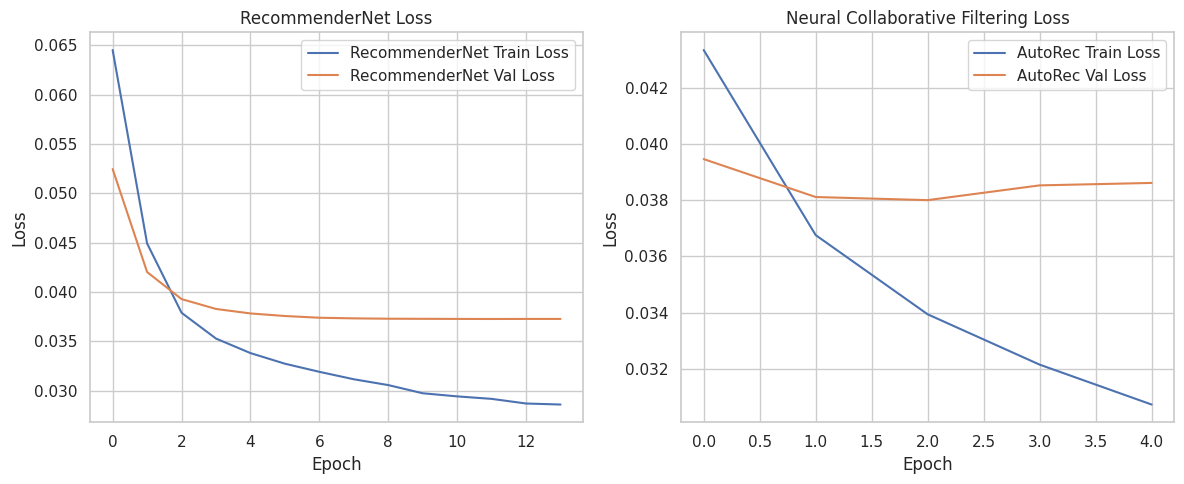

In [46]:
# Plot training and validation loss for both models side by side
plt.figure(figsize=(12,5))
# Plot loss for RecommenderNet
plt.subplot(1,2,1)
plt.plot(history_recommenderNet.history['loss'], label='RecommenderNet Train Loss')
plt.plot(history_recommenderNet.history['val_loss'], label='RecommenderNet Val Loss')
plt.title('RecommenderNet Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# Plot loss for Neural Collaborative Filtering (NCF)
plt.subplot(1,2,2)
plt.plot(history_ncf.history['loss'], label='AutoRec Train Loss')
plt.plot(history_ncf.history['val_loss'], label='AutoRec Val Loss')
plt.title('Neural Collaborative Filtering Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
631/631 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


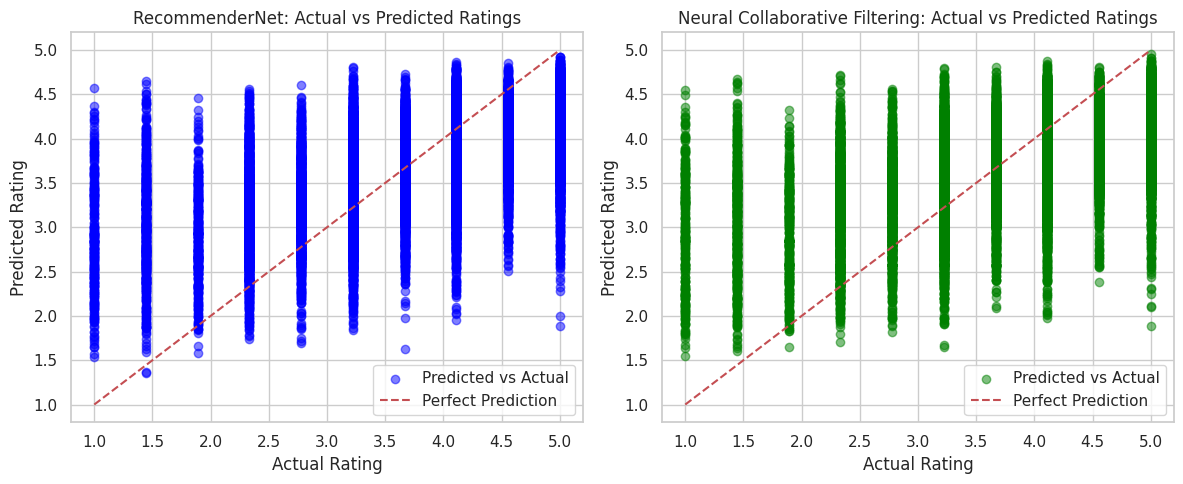

In [47]:
# Predict ratings for validation set and rescale predictions
# Predict with RecommenderNet
X_val_combined = np.column_stack((X_val[:, 0], X_val[:, 1]))
y_pred_recommenderNet = model.predict(X_val_combined).flatten()
y_true_recommenderNet = y_val.flatten()

# Predict with Neural Collaborative Filtering (NCF)
X_val_user = X_val[:, 0]
X_val_item = X_val[:, 1]
y_pred_ncf = model_ncf.predict([X_val_user, X_val_item]).flatten()
y_true_ncf = y_val.flatten()

# Rescale predictions and true values from [0,1] to [1,5]
y_pred_recommenderNet = y_pred_recommenderNet * 4 + 1
y_true_recommenderNet = y_true_recommenderNet * 4 + 1
y_pred_ncf = y_pred_ncf * 4 + 1
y_true_ncf = y_true_ncf * 4 + 1

# Visualize Actual vs Predicted ratings
plt.figure(figsize=(12, 5))
# RecommenderNet plot
plt.subplot(1, 2, 1)
plt.scatter(y_true_recommenderNet, y_pred_recommenderNet, alpha=0.5, color='blue', label='Predicted vs Actual')
plt.plot([1, 5], [1, 5], 'r--', label='Perfect Prediction')
plt.title('RecommenderNet: Actual vs Predicted Ratings')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.legend()
plt.grid(True)
# Neural Collaborative Filtering plot
plt.subplot(1, 2, 2)
plt.scatter(y_true_ncf, y_pred_ncf, alpha=0.5, color='green', label='Predicted vs Actual')
plt.plot([1, 5], [1, 5], 'r--', label='Perfect Prediction')
plt.title('Neural Collaborative Filtering: Actual vs Predicted Ratings')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
# Calculate RMSE and MAE for RecommenderNet predictions
rmse_rec = np.sqrt(mean_squared_error(y_true_recommenderNet, y_pred_recommenderNet))
mae_rec = mean_absolute_error(y_true_recommenderNet, y_pred_recommenderNet)
# Calculate RMSE and MAE NCF predictions
rmse_autorec = np.sqrt(mean_squared_error(y_true_ncf, y_pred_ncf))
mae_autorec = mean_absolute_error(y_true_ncf, y_pred_ncf)
print(f"RecommenderNet - RMSE: {rmse_rec:.4f}, MAE: {mae_rec:.4f}")
print(f"Neural Collaborative Filtering - RMSE: {rmse_autorec:.4f}, MAE: {mae_autorec:.4f}")

RecommenderNet - RMSE: 0.7601, MAE: 0.5843
Neural Collaborative Filtering - RMSE: 0.7773, MAE: 0.5992


305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


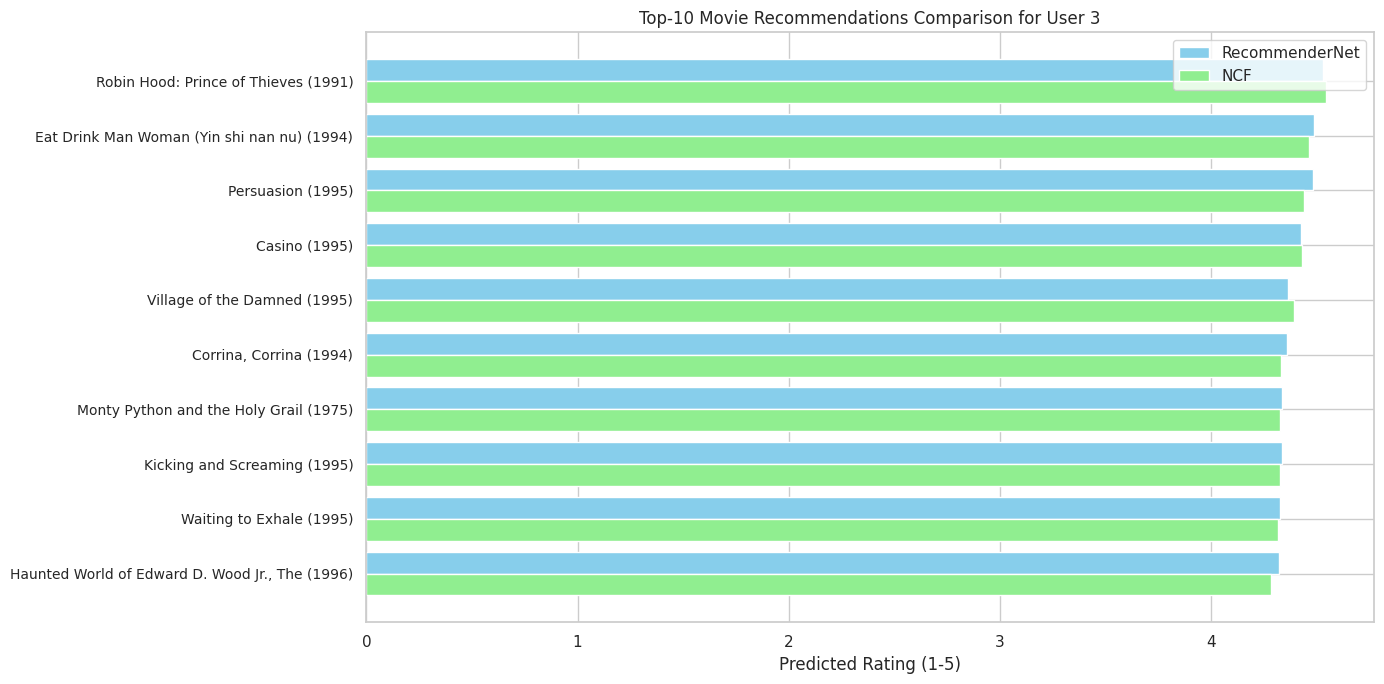

In [58]:
# Function for RecommenderNet
def get_top_n_recommendations(model, user_id, all_movie_ids, movies_df, N=10):
    user_array = np.array([user_id] * len(all_movie_ids))
    predictions = model.predict(np.column_stack((user_array, all_movie_ids))).flatten()
    top_indices = np.argsort(predictions)[::-1][:N]
    top_movie_ids = all_movie_ids[top_indices]
    top_scores = predictions[top_indices] * 5  # Asumsi skala 1-5
    top_movies = movies_df[movies_df['movieId'].isin(top_movie_ids)].copy()
    top_movies['predicted_rating'] = top_movies['movieId'].map(dict(zip(top_movie_ids, top_scores)))
    top_movies = top_movies.sort_values(by='predicted_rating', ascending=False).reset_index(drop=True)
    top_movies.index += 1
    return top_movies[['movieId', 'title', 'predicted_rating']]

# Function for NCF (Neural Collaborative Filtering)
def get_top_n_recommendations_ncf(model_ncf, user_id, movie_indices, movies_df, movie_mapping, N=10):
    user_array = np.array([user_id] * len(movie_indices))
    predictions = model_ncf.predict([user_array, movie_indices], verbose=0).flatten()
    top_indices = np.argsort(predictions)[::-1][:N]
    top_movie_indices = movie_indices[top_indices]
    top_scores = predictions[top_indices] * 5  # Asumsi skala 1-5
    index_to_movie = {v: k for k, v in movie_mapping.items()}
    top_movie_ids = [index_to_movie[idx] for idx in top_movie_indices]
    top_movies = movies_df[movies_df['movieId'].isin(top_movie_ids)].copy()
    top_movies['predicted_rating'] = top_movies['movieId'].map(dict(zip(top_movie_ids, top_scores)))
    top_movies = top_movies.sort_values(by='predicted_rating', ascending=False).reset_index(drop=True)
    top_movies.index += 1
    return top_movies[['movieId', 'title', 'predicted_rating']]

# Set the Target User
user_id = 3
all_movie_ids = movies['movieId'].values
movie_indices = np.array(list(movie_mapping.values()))
top_n = 10

# Generate the Top 10 Recommendations
top_n_rec_recommender = get_top_n_recommendations(model, user_id, all_movie_ids, movies, N=top_n)
top_n_rec_ncf = get_top_n_recommendations_ncf(model_ncf, user_id, movie_indices, movies, movie_mapping, N=top_n)

#  Visualization: Bar Chart Comparison
titles_rec = top_n_rec_recommender['title'].values
scores_rec = top_n_rec_recommender['predicted_rating'].values
titles_ncf = top_n_rec_ncf['title'].values
scores_ncf = top_n_rec_ncf['predicted_rating'].values
ind = np.arange(len(titles_rec))
width = 0.4
plt.figure(figsize=(14, 7))
plt.barh(ind - width/2, scores_rec, height=width, color='skyblue', label='RecommenderNet')
plt.barh(ind + width/2, scores_ncf, height=width, color='lightgreen', label='NCF')
plt.yticks(ind, titles_rec, fontsize=10)
plt.xlabel('Predicted Rating (1-5)')
plt.title(f'Top-{top_n} Movie Recommendations Comparison for User {user_id}')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()